In [3]:
!pip install folium
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import folium
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime
import datetime
import statsmodels.formula.api as sm 

In [4]:
original = pd.read_excel('Traffic_big.xlsx')

In [5]:
# Converting the Latitude and Longitude Attributes to a Float
original["Latitude"] = original["Latitude"].astype(float)
original["Longitude"] = original["Longitude"].astype(float)

# Combining The Datetime and TimeStamp together to form Datetime Objects
dt = []
for index, row in original.iterrows():
    time = datetime.datetime.combine(row['Date Of Stop'], row['Time Of Stop'])
    dt.append(time)
    
original['datetime'] = pd.to_datetime(dt) 

original = original[original["Gender"] != "U"]
original = original[(original["Year"] != 0) & (original["Year"] < 2020) & (original["Year"] > 1900)]


In [6]:
filtered_cols = ["Date Of Stop", "Time Of Stop", "datetime", "SubAgency", 
                 "Description", "Location", "Latitude", "Longitude",
                 "Accident", "Belts", "Personal Injury", "Property Damage",
                 "Fatal", "Alcohol", "Work Zone", "VehicleType",
                 "Year", "Make", "Violation Type", "Contributed To Accident",
                 "Race", "Gender", "DL State"]

# Can break up the criteria above to make the dataframe more tidy
fil_df = original[filtered_cols]

In [7]:
# Make a sample (of size 5000) of the Traffic Violation dataset
sam = fil_df.sample(n = 5000)

In [8]:
def generate_map(loc = [39.1247, -77.1905], zoom = 10.5, tile = "openstreetmap"):
    res_map = folium.Map(location = loc, zoom_start = zoom, control_scale = True, tiles = tile)
    
    # Add the Tile (or Style) of the Map
    folium.TileLayer('openstreetmap').add_to(res_map)
    folium.TileLayer('Stamen Watercolor').add_to(res_map)
    folium.TileLayer('Stamen Toner').add_to(res_map)
    return res_map
    

In [9]:
# This Function returns the designated color assigned to a race.
def color_select(race):
    ethnicity = {'ASIAN': "#ed8134", # Orange
                 'BLACK': "#391cba", #Indigo
                 'HISPANIC': "#119992", #Teal 
                 'NATIVE AMERICAN': "#9412b8", # Violet 
                 'OTHER': "#127bb8", # Blue
                 'WHITE': "#e81c1c"} # Red
    
    return ethnicity[race]

# Map Exploring the Race and Gender 

In [10]:
# Creating an Empty Map
map_total = generate_map()

# other mapping code (e.g. lines, markers etc.)
asian_fg = folium.FeatureGroup(name = "Asian") 
black_fg = folium.FeatureGroup(name = "Black") 
his_fg = folium.FeatureGroup(name = "Hispanic") 
na_fg = folium.FeatureGroup(name = "Native American") 
other_fg = folium.FeatureGroup(name = "Other") 
white_fg = folium.FeatureGroup(name = "White") 

race = {'ASIAN': asian_fg, 
        'BLACK': black_fg, 
        'HISPANIC': his_fg, 
        'NATIVE AMERICAN': na_fg, 
        'OTHER': other_fg, 
        'WHITE': white_fg} 

for ind, row in sam.iterrows():
    
    entry = (folium.RegularPolygonMarker(location = [row["Latitude"],row["Longitude"]], popup = row["Description"], 
                                        color= color_select(row["Race"]), fill = True, weight = 1, 
                                        number_of_sides = 3 if row["Gender"] == "M" else 6, 
                                        radius = 4, opactity = .4))
    entry.add_to(race[row["Race"]])

for r in race:
    race[r].add_to(map_total)
    
folium.LayerControl().add_to(map_total)

map_total

## Bar Graph Relating Gender, Race, and the number of Traffic Violation

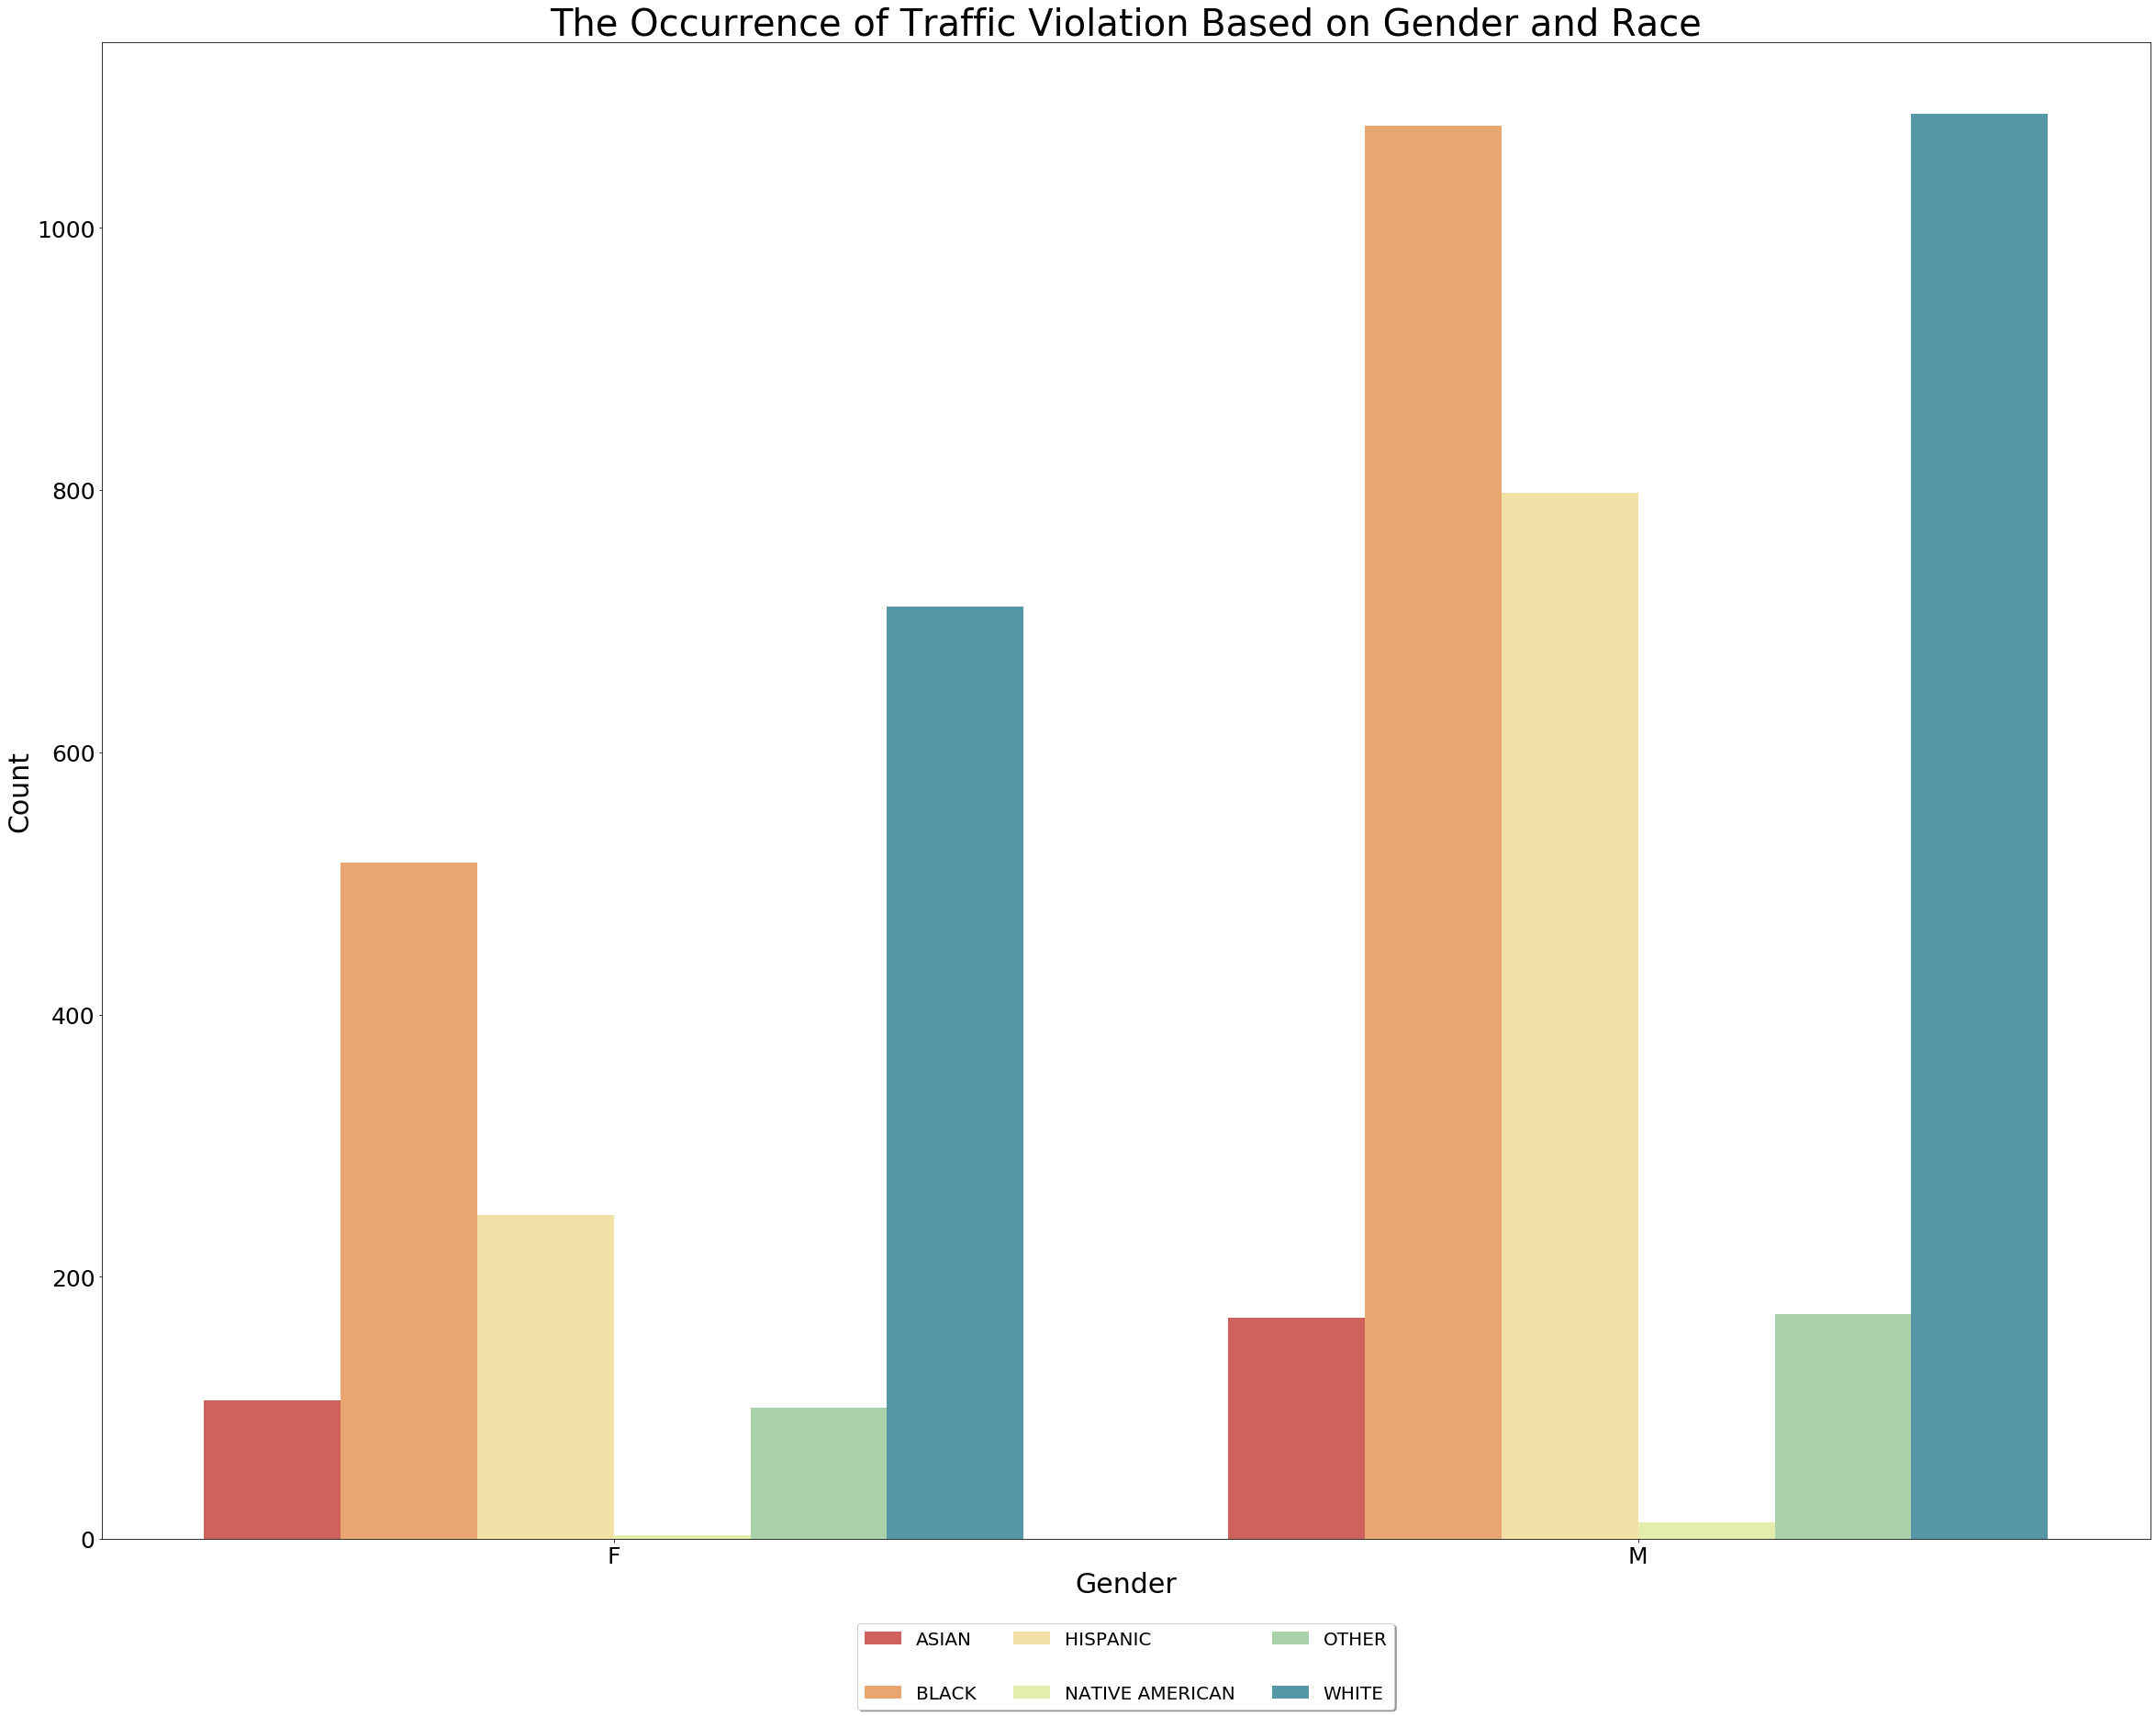

In [11]:
gr_df = sam.copy()
gr_df["count"] = 1

aggregation_functions = {'count': 'sum'}
nd = gr_df.groupby(['Gender', 'Race']).aggregate(aggregation_functions)

# Setting up the plot and dimension
fig, axs = plt.subplots() 
fig.set_figheight(30)
fig.set_figwidth(40)

b1 = sns.barplot(x="Gender", y ="count", hue="Race", palette = "Spectral", data=nd.reset_index(), ax = axs)
b1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3, labelspacing=2, fontsize = 20)

b1.set_title("The Occurrence of Traffic Violation Based on Gender and Race", fontsize = 40)
b1.set_ylabel("Count", fontsize = 30)
b1.set_xlabel("Gender", fontsize = 30)
b1.tick_params(axis='both', labelsize=25)

plt.show()

# HeatMap Exploring the Occurrence based on Time (Hours)

In [12]:
sam["hour"] = [t.hour for t in sam["Time Of Stop"]]
cut = pd.cut(sam["hour"], bins = [0,2,4,6,8,10,12,14,16,18,20,22,24], 
             labels = [1,2,3,4,5,6,7,8,9,10,11,12], right = False)
sam["cut"] = cut

In [13]:
df_copy = sam.copy()
df_copy['count'] = 1
hr_map = generate_map()

hm_fg = []
hr = 0
for ind in range(12):
    temp_name = "Hours " + str(hr) + " to " + str(hr + 1)
    hm_fg.append(folium.FeatureGroup(name = temp_name, show= True if ind == 0 else False))
    hr += 2


# Group time together to have more during a specifc set of hours\
for index in range(12):    
    temp = df_copy[df_copy["cut"] == index + 1]
    HeatMap(data=temp[['Latitude', 'Longitude', 'count']]
                .groupby(['Latitude', 'Longitude', 'count'])
                .sum()
                .reset_index()
                .values.tolist(), 
                radius=8, max_zoom=13).add_to(hm_fg[index])
    
for fg in hm_fg:
    fg.add_to(hr_map)
        
    
folium.LayerControl().add_to(hr_map)

hr_map

## HeatMap Over Time

In [14]:
time_map = generate_map()
df_hour_list = []
for hour in df_copy["cut"].sort_values().unique():
    df_hour_list.append(df_copy.loc[df_copy.hour == hour, ['Latitude', 'Longitude', 'count']]
                        .groupby(['Latitude', 'Longitude']).sum().reset_index().values.tolist())

HeatMapWithTime(df_hour_list, radius=8, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, 
                min_opacity=0.5, max_opacity=0.8, use_local_extrema=True, auto_play=True).add_to(time_map)

folium.LayerControl().add_to(time_map)

time_map

# Total HeatMap

In [15]:
df_copy = sam.copy()
df_copy['count'] = 1
base_map = generate_map()

HeatMap(data=df_copy[['Latitude', 'Longitude', 'count']]
            .groupby(['Latitude', 'Longitude', 'count'])
            .sum()
            .reset_index()
            .values.tolist(), 
            radius=8, max_zoom=13).add_to(base_map)

folium.LayerControl().add_to(base_map)

base_map

# Exploring the Vehicle Type and Year

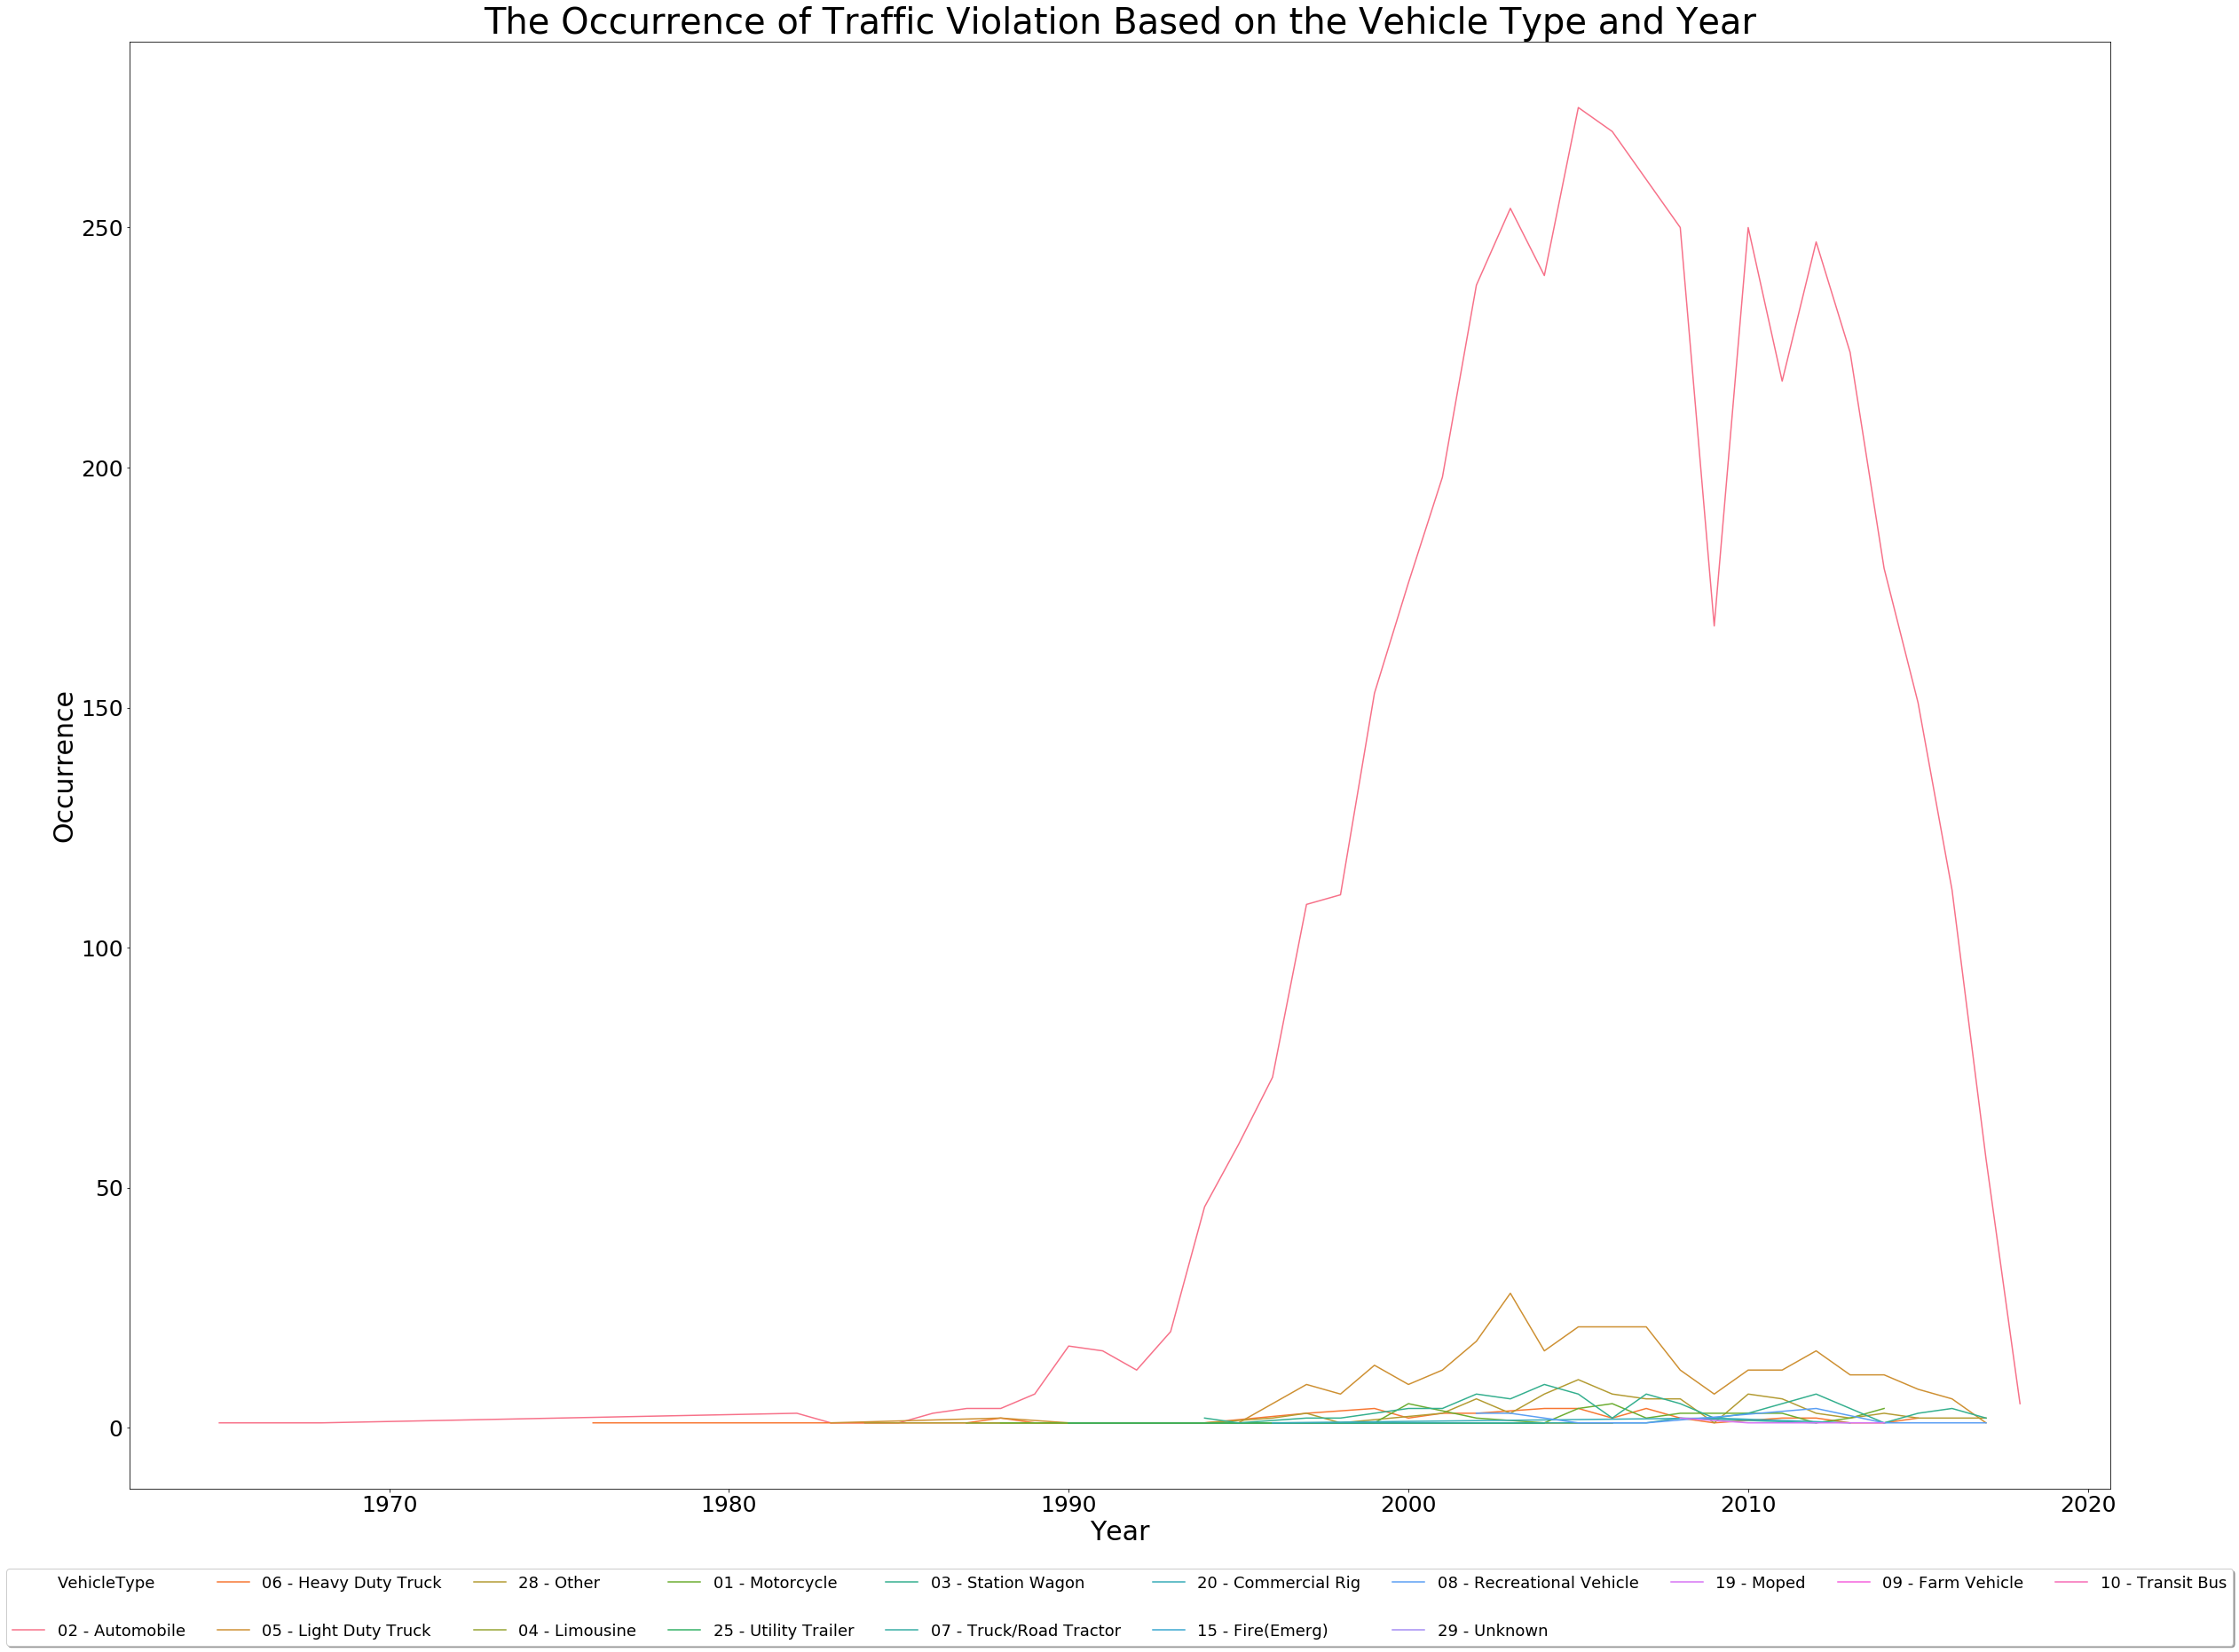

In [16]:
##### VehicleType, Year, Make
vy_df = sam.copy()
vy_df['count'] = 1
vy_df = vy_df.sort_values("Year")

aggregation_functions = {'count': 'sum'}
nd2 = vy_df.groupby(['Year', 'VehicleType']).aggregate(aggregation_functions)


# Setting up the plot and dimension
fig, axs = plt.subplots() 
fig.set_figheight(30)
fig.set_figwidth(40)

l = sns.lineplot(x = "Year", y = "count", hue = "VehicleType",data = nd2.reset_index(), ax = axs)
l.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=10, labelspacing=2, fontsize = 18)

l.set_title("The Occurrence of Traffic Violation Based on the Vehicle Type and Year", fontsize = 40)
l.set_ylabel("Occurrence", fontsize = 30)
l.set_xlabel("Year", fontsize = 30)
l.tick_params(axis='both', labelsize=25)

plt.show()

# Linear Regression

In [17]:
district = np.unique(original["SubAgency"])
simp_district = {}

for dist in district:
    if dist[0] == "H":
        simp_district[dist] = 7
    else:
        simp_district[dist] = int(dist[0])


In [18]:
race_num = {'ASIAN': 0, 
            'BLACK': 1, 
            'HISPANIC': 2, 
            'NATIVE AMERICAN': 3, 
            'OTHER': 4, 
            'WHITE': 5} 

In [19]:
vt = {"Warning": 1,
      "Citation": 2,
      "ESERO": 3,
      "SERO": 4}

In [20]:
data_reg = sam.copy()

data_reg["district_num"] = [simp_district[d] for d in data_reg["SubAgency"]]
data_reg["gender_num"] = [0 if g == "M" else 1 for g in data_reg["Gender"] ]
data_reg["race_num"] = [race_num[r] for r in data_reg["Race"]]
data_reg["violation_type_num"] = [vt[v] for v in data_reg["Violation Type"]]

data_reg

Date Of Stop Time Of Stop            datetime  \
77534   2017-07-05     06:34:00 2017-07-05 06:34:00   
7786    2016-02-29     13:15:00 2016-02-29 13:15:00   
63991   2015-02-11     20:26:00 2015-02-11 20:26:00   
57928   2017-03-08     22:45:00 2017-03-08 22:45:00   
52207   2017-02-06     01:25:00 2017-02-06 01:25:00   
...            ...          ...                 ...   
28991   2016-02-04     21:38:00 2016-02-04 21:38:00   
49952   2016-06-15     10:08:00 2016-06-15 10:08:00   
93675   2016-04-19     12:51:00 2016-04-19 12:51:00   
72664   2015-01-18     19:35:00 2015-01-18 19:35:00   
28009   2018-04-05     15:00:00 2018-04-05 15:00:00   

                         SubAgency  \
77534        4th district, Wheaton   
7786      5th district, Germantown   
63991     5th district, Germantown   
57928  3rd district, Silver Spring   
52207       2nd district, Bethesda   
...                            ...   
28991       2nd district, Bethesda   
49952      1st district, Rockville   
93675        4th district, Wheaton   
72664      1st district, Rockville   
28009  3rd district, Silver Spring   

                                             Description  \
77534  FAILURE OF INDIVIDUAL DRIVING ON HIGHWAY TO DI...   
7786   DRIVER FAILURE TO OBEY PROPERLY PLACED TRAFFIC...   
63991     DISPLAYING REG. PLATE ISSUED FOR OTHER VEHICLE   
57928  PERSON DRIVING MOTOR VEHICLE ON HIGHWAY OR PUB...   
52207                  DRIVING WHILE IMPAIRED BY ALCOHOL   
...                                                  ...   
28991  DRIVING VEHICLE ON HIGHWAY WITHOUT CURRENT REG...   
49952  DRIVER USING HANDS TO USE HANDHELD TELEPHONE W...   
93675                       FAILURE TO STOP AT STOP SIGN   
72664  EXCEEDING MAXIMUM SPEED: 44 MPH IN A POSTED 35...   
28009  FAIL OF DRIVER IN ATTENDED VEHICLE ACCIDENT TO...   

                                     Location   Latitude  Longitude Accident  \
77534                RANDOLPH RD @ BLUHILL RD  39.059008 -77.065487       No   
7786        STRINGTOWN RD @ SNOWDEN FARM PKWY  39.244095 -77.263673       No   
63991               MIDDLEBROOK @ CROSS RIDGE  39.174925 -77.259038       No   
57928           FENTON ST @ SILVER SPRING AVE  38.997718 -77.024608       No   
52207      OLD GEORGETOWN RD @ DEMOCRACY BLVD  38.983335 -77.094818       No   
...                                       ...        ...        ...      ...   
28991       DEMOCRACY BLVD/ OLD GEORGETOWN RD  39.023542 -77.128128       No   
49952           DIAMONDBACK RD @ BENT TWIG LA  39.114998 -77.214355       No   
93675            GRANDVIEW AVE@ BLUERIDGE AVE  39.041602 -77.053187       No   
72664                 WOODFIELD RD / FAITH LN  39.298523 -77.199713       No   
28009  WB BRIGGS CHANEY RD AT OLD COLUMBIA PK  39.053315 -76.962432       No   

      Belts  ... Contributed To Accident      Race Gender DL State hour cut  \
77534    No  ...                      No  HISPANIC      M       MD    6   4   
7786     No  ...                      No  HISPANIC      F       MD   13   7   
63991    No  ...                      No     BLACK      F       MD   20  11   
57928    No  ...                      No     BLACK      M       MD   22  12   
52207    No  ...                      No     BLACK      M       VA    1   1   
...     ...  ...                     ...       ...    ...      ...  ...  ..   
28991    No  ...                      No     ASIAN      F       MD   21  11   
49952    No  ...                      No     WHITE      M       MD   10   6   
93675    No  ...                      No     WHITE      M       MD   12   7   
72664    No  ...                      No     WHITE      M       PA   19  10   
28009    No  ...                      No     WHITE      M       MD   15   8   

       district_num gender_num race_num violation_type_num  
77534             4          0        2                  2  
7786              5          1        2                  1  
63991             5          1        1                  2  
57928        

In [21]:
#mlr = sm.ols(formula = 'lifeExp ~ year + continent_Asia + continent_Africa + continent_Europe + continent_Americas + continent_Oceania + year*continent_Asia + year*continent_Africa + year*continent_Europe + year*continent_Americas + year*continent_Oceania', data = data).fit()   
distlr = sm.ols(formula = 'district_num ~ Year + gender_num + race_num + violation_type_num', data = data_reg).fit()   

distlr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           district_num   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     11.23
Date:                Fri, 13 Dec 2019   Prob (F-statistic):           4.51e-09
Time:                        16:39:58   Log-Likelihood:                -9502.5
No. Observations:                5000   AIC:                         1.902e+04
Df Residuals:                    4995   BIC:                         1.905e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             38.2829      7.642      5.009      0.000      23.301      53.265
Year                  -0.0171      0.004     -4.493      0.000      -0.025      -0.010
gender_num            -0.0587      0.049     -1.196      0.232      -0.155       0.038
race_num              -0.0420      0.012     -3.367      0.001      -0.066      -0.018
violation_type_num    -0.1448      0.046     -3.159      0.002      -0.235      -0.055
==============================================================================
Omnibus:                      336.547   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              138.130
Skew:                           0.174   Prob(JB):                     1.01e-30
Kurtosis:                       2.264   Cond. No.                     6.69e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.69e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""